In [1]:
PATH = r'..\data\processed\02_preprocced.csv'
MODEL_PATH = r'..\models\arabic_dialect.h5'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
import string
import re

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences


import tensorflow as tf
from keras.layers import GRU, Embedding, Dense, Input, Dropout, Bidirectional, CuDNNGRU
from tensorflow.keras.models import Sequential,Model
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping,ModelCheckpoint



In [6]:
df = pd.read_csv(PATH)

In [16]:
tknzr = Tokenizer(oov_token='UNK', split=" ")
tknzr.fit_on_texts(df['tweet_text'])
tknzr.num_words = 90000


#making sequences:
X = tknzr.texts_to_sequences(df['tweet_text'])
X = pad_sequences(X, padding='post', value=0,maxlen=100)

In [17]:
len(tknzr.word_counts),np.max(X)

(464417, 89999)

In [18]:
encode = {k:v for v,k in enumerate( df['dialect'].unique())}

In [19]:
df['encode'] = df['dialect'].apply(lambda x:encode[x])

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,df['encode'],test_size=0.03,shuffle = True)

In [21]:
y_train0 = tf.keras.utils.to_categorical(y_train)

In [27]:
model = Sequential()
model.add(Embedding(len(tknzr.word_index), 200))
model.add(Bidirectional(GRU(units = 256)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         92883600  
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              703488    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 18)                2322      
                                                                 
Total params: 93,655,074
Trainable params: 93,655,074
Non-trainable params: 0
__________________________________________

In [29]:

from keras.callbacks import EarlyStopping,ModelCheckpoint
callbacks_lst = [EarlyStopping(monitor='val_accuracy', mode='auto',patience=2)]
chkpt = ModelCheckpoint(filepath=MODEL_PATH, save_best_only=True,monitor="val_loss")

# Training
batch_size = 512
epochs = 20
print('Train...')
history = model.fit(X_train, y_train0,
          batch_size=batch_size,
          epochs=epochs,          
          # validation_data=(X_test, y_test),
          validation_split=0.03,
          callbacks=[callbacks_lst,chkpt])

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
843/843 [==============================] - 126s 146ms/step - loss: 2.0344 - accuracy: 0.3566 - val_loss: 1.6688 - val_accuracy: 0.4769
Epoch 2/20
843/843 [==============================] - 122s 145ms/step - loss: 1.4931 - accuracy: 0.5325 - val_loss: 1.5710 - val_accuracy: 0.5163
Epoch 3/20
843/843 [==============================] - 116s 138ms/step - loss: 1.2331 - accuracy: 0.6159 - val_loss: 1.6143 - val_accuracy: 0.5169
Epoch 4/20
843/843 [==============================] - 116s 137ms/step - loss: 1.0138 - accuracy: 0.6842 - val_loss: 1.7591 - val_accuracy: 0.5108
Epoch 5/20
843/843 [==============================] - 116s 137ms/step - loss: 0.8235 - accuracy: 0.7427 - val_loss: 2.0112 - val_accuracy: 0.5038


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

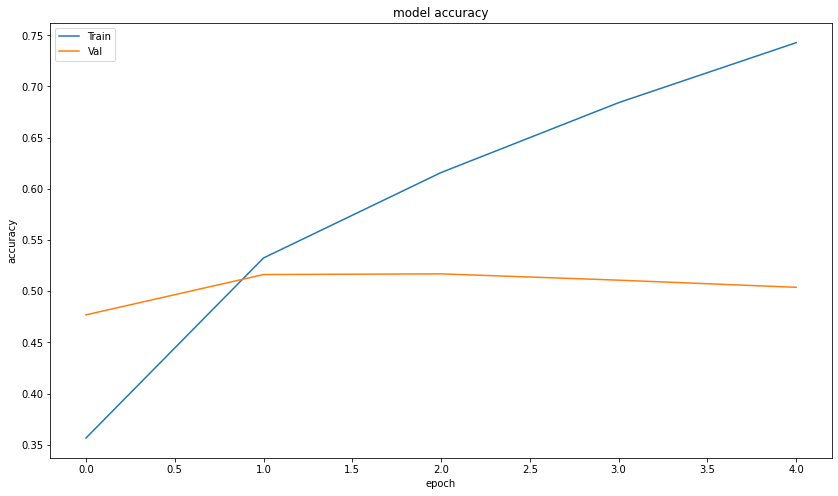

In [31]:
plt.figure(figsize=(14,8))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## This model has overfitting

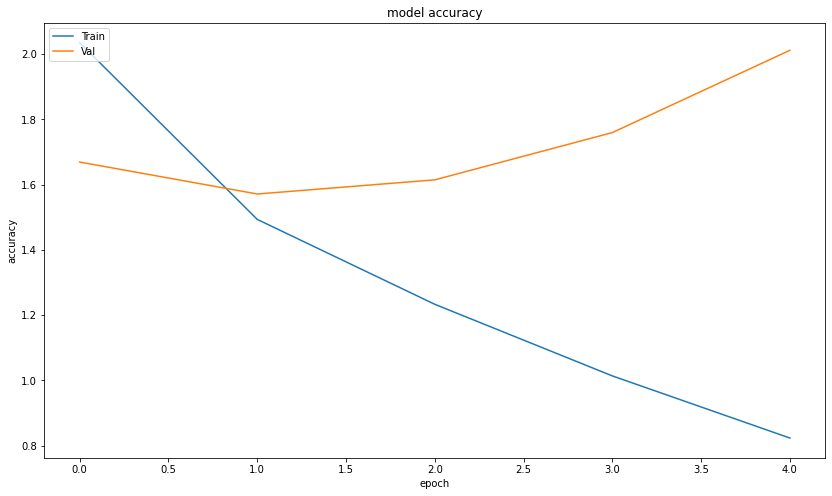

In [32]:
plt.figure(figsize=(14,8))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [33]:
y_pred =np.argmax(model.predict(X_test),axis=1)
print(sklearn.metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49       452
           1       0.64      0.62      0.63      1008
           2       0.51      0.39      0.45       929
           3       0.45      0.50      0.48      1339
           4       0.40      0.35      0.37       475
           5       0.64      0.48      0.55       298
           6       0.39      0.42      0.40       848
           7       0.66      0.60      0.63       346
           8       0.35      0.38      0.37       796
           9       0.29      0.16      0.21       271
          10       0.59      0.52      0.55       516
          11       0.72      0.80      0.76      1826
          12       0.61      0.55      0.57       797
          13       0.50      0.50      0.50      1266
          14       0.38      0.40      0.39       561
          15       0.66      0.57      0.61       414
          16       0.37      0.46      0.41       800
          17       0.35    

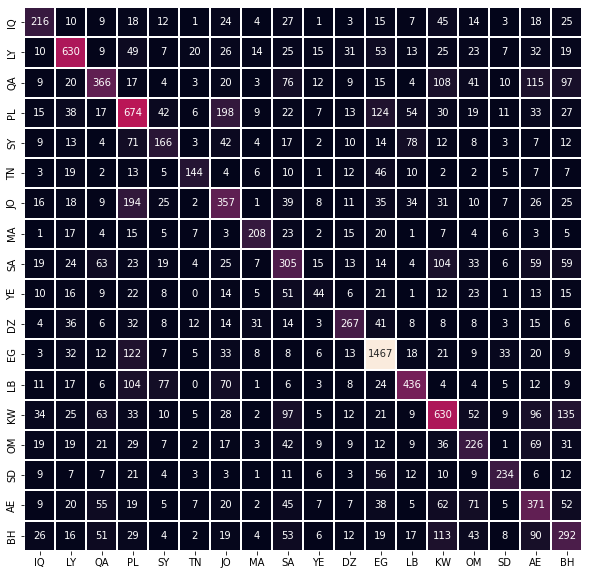

In [42]:
decode = {v:k for k,v in encode.items()}
labels = decode.values()
cf_matrix = sklearn.metrics.confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g',xticklabels=labels, yticklabels=labels,cbar=False,annot_kws={"fontsize":10})